# complex graph topologies 모델 만들기
- functional API 이용하여 복잡한 토폴러지 모델 만들어 보기
- output 2개에 대해 컴파일시 2개 loss 계산하도록 해보자
> 참고 링크 : https://keras.io/guides/functional_api/

### Complex Grapth Topology
![image](https://keras.io/img/guides/functional_api/functional_api_40_0.png)

In [1]:
import tensorflow as tf
import numpy as np

num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

# Input layer
Input_layer1 = tf.keras.layers.Input(shape=[None], name='title')
Input_layer2 = tf.keras.layers.Input(shape=[None], name='body')
Input_layer3 = tf.keras.layers.Input(shape=[12], name='tags')

# Emdedding layer
Emb_layer1 = tf.keras.layers.Embedding(num_words, 64)(Input_layer1)
Emb_layer2 = tf.keras.layers.Embedding(num_words, 32)(Input_layer2)

# LSTM layer
Lstm_layer1 = tf.keras.layers.LSTM(128, activation='relu')(Emb_layer1)
Lstm_layer2 = tf.keras.layers.LSTM(32, activation='relu')(Emb_layer2)

# Concatenate layer
Concat_layer1 = tf.keras.layers.concatenate([Lstm_layer1, Lstm_layer2, Input_layer3])

# Output layer : Activation을 지정하지 않고 compile시에 지정함.
Output_layer1 = tf.keras.layers.Dense(1, name='priority')(Concat_layer1)
Output_layer2 = tf.keras.layers.Dense(4, name='department')(Concat_layer1)

model = tf.keras.Model(inputs=[Input_layer1, Input_layer2, Input_layer3], outputs=[Output_layer1, Output_layer2])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
body (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     640000      title[0][0]                      
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 32)     320000      body[0][0]                       
______________________________________________________________________________________________

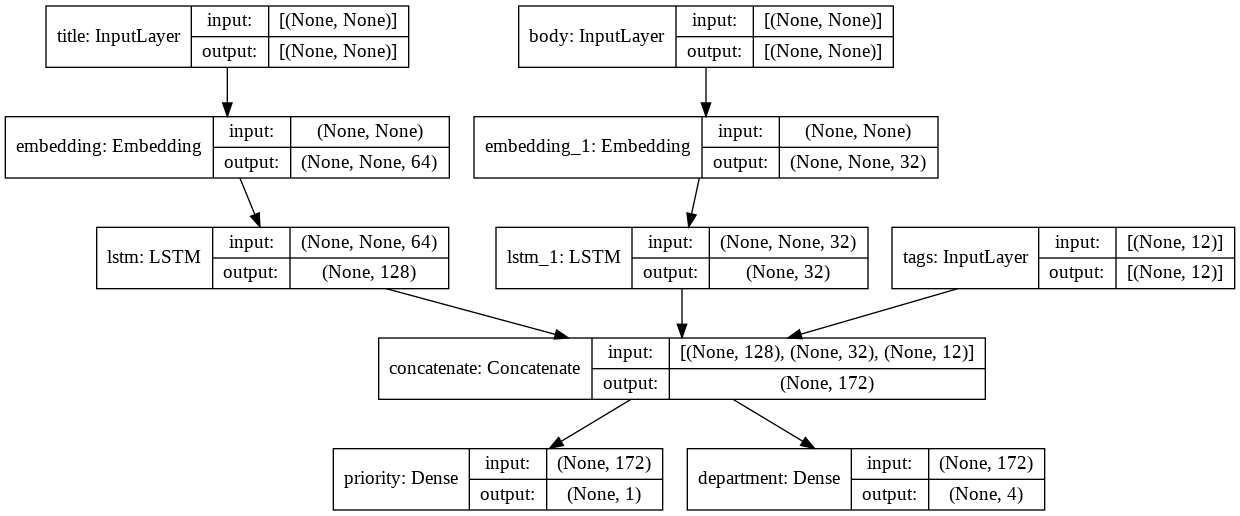

In [2]:
tf.keras.utils.plot_model(model,  show_shapes=True)

In [3]:
# 모델 레이어 보기
model.layers

In [4]:
# 맨 아래 Dense layer 상세 내용 보기: Weight, Bias
dense_lstm = model.layers[9]
print('# Coef Shape:',dense_lstm.get_weights()[0].shape)
print('# Bias Shape',dense_lstm.get_weights()[1].shape)

# Coef Shape: (172, 4)
# Bias Shape (4,)


In [5]:
# 결과가 2개 나오고 각 결과에 대한 Loss를 따로 지정
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(1e-3),
    loss={
        "priority": tf.keras.losses.BinaryCrossentropy(from_logits=True),
        "department": tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights=[1.0, 0.2],
)

In [6]:
# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data},
    {"priority": priority_targets, "department": dept_targets},
    epochs=2,
    batch_size=32,
)

Epoch 1/2
40/40 [==============================] - 8s 76ms/step - loss: 25200.8349 - priority_loss: 13795.9270 - department_loss: 57024.5395
Epoch 2/2
40/40 [==============================] - 3s 77ms/step - loss: 79029221.1159 - priority_loss: 38973583.0671 - department_loss: 200278166.8049
